# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
# !pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch

from agent import Agent
from train_eval import evaluate_agent, train_agent
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
# env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis.x86_64")
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [9]:
# for i in range(1, 30):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

# env.close()

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# Try with DDPG. Agents are sharing experiences

In [7]:
# local_path = os.path.dirname(os.path.abspath(__file__))
# local_env_path = local_path + "/Tennis.app"
start_time = datetime.now()
TRAIN = False

# VARS
config = {
    "buffer_size": int(1e6),  # replay buffer size
    "batch_size": 1024,  # minibatch size
    "replay_initial": 1024,  # initial memory before updating the network
    "gamma": 0.99,  # discount factor
    "lr_actor": 1e-4,  # learning rate
    "lr_critic": 1e-3,  # learning rate of the critic
    "update_every": 2,  # how often to update the network
    "tau": 1e-3,  # soft update
    "weight_decay": 0,  # l2 weight decay
    "net_body": (256, 128, 64),  # hidden layers
    "per_alpha": 0.6,
    "per_beta": 0.4,
    "per_beta_increment": 0.0001,
    "per_epsilon": 0.0001,
    "prioritized": True,
}

agent = Agent(
    state_size=state_size,
    action_size=action_size,
    random_seed=0,
    num_agents=num_agents,
    **config
)

Train Agent for 26000 episodes
Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.05
Episode 1100	Average Score: 0.08
Episode 1200	Average Score: 0.13
Episode 1300	Average Score: 0.15
Episode 1400	Average Score: 0.16
Episode 1500	Average Score: 0.09
Episode 1600	Average Score: 0.09
Episode 1700	Average Score: 0.20
Episode 1800	Average Score: 0.21
Episode 1900	Average Score: 0.36
Episode 2000	Average Score: 0.42
Episode 2093	Average Score: 0.50
Environment solved in 2093 episodes!	Average Score: 0.50

Time elapsed (hh:mm:ss.ms) 1:09:33.729971


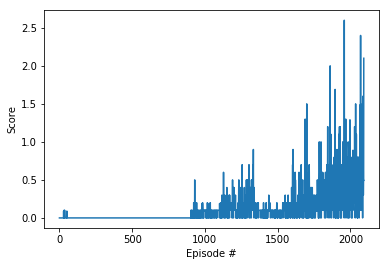

In [11]:
# from workspace_utils import active_session

if TRAIN:
#     with active_session():
    n_episodes = 5000
    min_score = 1
    print(f"Train Agent for {n_episodes} episodes, stop if min average score = {min_score}")
    scores = train_agent(agent, env, n_episodes=n_episodes, min_score=min_score)
    time_elapsed = datetime.now() - start_time
    print("\nTime elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

    # Plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()

In [8]:
# Evaluate agent (using solved agent)
print("Evaluate (solved) Agent")
checkpoint_pth = "scores/checkpoint_env_solved_{}_PER.pth"
evaluate_agent(
    agent, env, num_agents=num_agents, checkpoint_pth=checkpoint_pth, num_episodes=10, min_score=.5
)

Evaluate (solved) Agent
Total score (averaged over agents) for episode 0: 0.19000000320374966
Total score (averaged over agents) for episode 1: 2.600000038743019
Total score (averaged over agents) for episode 2: 1.8000000268220901
Total score (averaged over agents) for episode 3: 0.5000000074505806
Total score (averaged over agents) for episode 4: 0.9000000134110451
Total score (averaged over agents) for episode 5: 0.0
Total score (averaged over agents) for episode 6: 0.800000011920929
Total score (averaged over agents) for episode 7: 1.0000000149011612
Total score (averaged over agents) for episode 8: 0.30000000447034836
Total score (averaged over agents) for episode 9: 0.20000000298023224


In [9]:
env.close()